# Recommend RBS sequences - Escherichia coli

This notebook shows the online recommendation of RBS sequences with the goal of achieving a high protein expression level.

There are several parts of the implementation. 

- Reading the dataset
- Embedding
    - One-hot embedding
    - K-mer 
    - PMW
    - Kernels
    - Unsupervised 
- Create reward environment
- Apply bandits algorithms
    - GPUCB

## Some open questions

- How to define arms? In this notebook, we consider an RBS sequence is an arm, where arms are dependent (we assume similar sequences having similar protein expression levels). Are there any other ways to define arms? For example, how about define arms as different experts, where each expert recommends one arm.

- How to recommend multiple arms once?

- How to select embedding methods? How to evaluate them?

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

import pandas
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading the Dataset

In [3]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/trainset.rbs1.v2.csv'

df = pandas.read_csv(Path, delimiter=',')
df.head()

,Construct,Barcode,rbs1_1_A,rbs1_1_C,rbs1_1_G,rbs1_1_T,rbs1_2_A,rbs1_2_C,rbs1_2_G,rbs1_2_T,...,rbs2_3_A,rbs2_3_C,rbs2_3_G,rbs2_3_T,Group,ODind,ODhar,FC,rbs1,rbs2
0,RBS629,77DD32,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.410,4.523,1.437982,GGG,GGG
1,RBS678,77DD39,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.359,2.678,1.277175,GGG,GGG
2,RBS353,77DD18,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.334,1.745,1.545141,GGC,GGG
3,RBS403,77DD20,0,0,1,0,0,0,1,0,...,1,0,0,0,Top,0.390,2.166,1.670098,GGC,GGA
4,RBS500,77DD24,0,0,1,0,0,0,1,0,...,0,1,0,0,Top,0.375,2.348,1.621230,GGC,GGC


In [4]:
df['RBS'] = df['rbs1'] + df['rbs2']
data = np.asarray(df[['RBS', 'FC']])
data.shape

(60, 2)

## Regression

potentail bugs: all kernels have same performance?

### Kernel Ridge Regression 

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function spectrum_kernel_pw at 0x7f91bfd6c1e0>,
            kernel_params=None)
[0.68609275 0.23891753 0.48532303 0.63799999 0.83987297 0.43694724
 0.39238463 0.73730976 0.24191408 0.73661958]
R2 score: 0.54 (+/- 0.41)


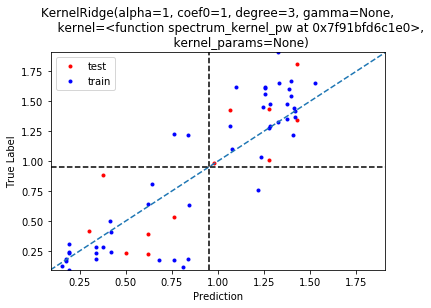

In [5]:
# Kernel Ridge Regression with spectrum kernel (l = 3, callable pass) 
# label embedding 

reg = Regression(KernelRidge(kernel = spectrum_kernel_pw), data, embedding_method='label')
reg.train()
reg.evaluate(cross_val_flag = True, k = 10)

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function mixed_spectrum_kernel_pw at 0x7f91bfd6c268>,
            kernel_params=None)
[0.69472847 0.23706334 0.48246922 0.63536774 0.85240862 0.42454808
 0.4048826  0.72910376 0.24695293 0.74115682]
R2 score: 0.54 (+/- 0.41)


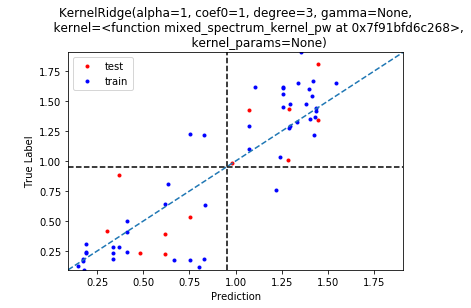

In [6]:
# Kernel Ridge Regression with mixed spectrum kernel (l = 3, callable pass) 
# label embedding 

reg = Regression(KernelRidge(kernel = mixed_spectrum_kernel_pw), data, embedding_method='label')
reg.train()
reg.evaluate(cross_val_flag = True, k = 10)

### Gaussian Process Regression

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function spectrum_kernel_pw at 0x7f91bfd6c1e0>),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
[0.70741335 0.19158025 0.16697755 0.48326713 0.68756985 0.10140272
 0.47120654 0.53151933 0.20068947 0.65384718]
R2 score: 0.42 (+/- 0.44)


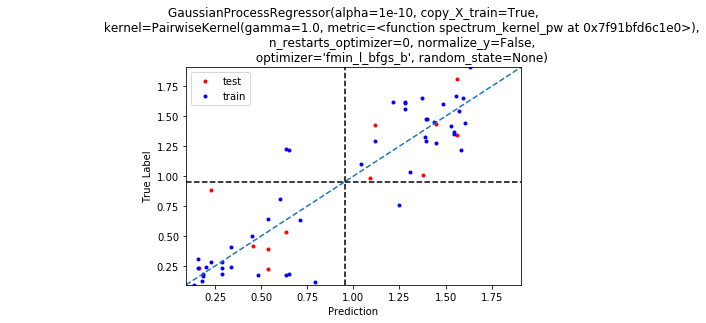

In [8]:
# Gaussian Process Regression with spectrum kernel (l = 3, callable pass)
# label embedding

reg = Regression(GaussianProcessRegressor(kernel = PairwiseKernel(metric = spectrum_kernel_pw)), data,\
                 embedding_method='label')
reg.train()
reg.evaluate(cross_val_flag = True, k = 10)

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function mixed_spectrum_kernel_pw at 0x7f91bfd6c268>),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
[0.70741686 0.19157704 0.16697457 0.48327317 0.68756849 0.10139777
 0.47120912 0.53151589 0.20068345 0.65385191]
R2 score: 0.42 (+/- 0.44)


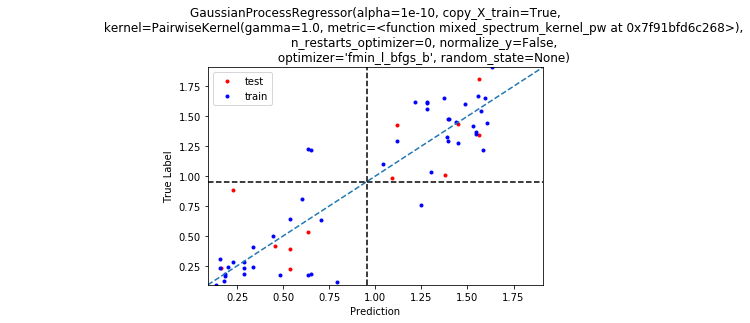

In [9]:
# Gaussian Process Regression with mixed spectrum kernel (l = 3, callable pass)
# label embedding

reg = Regression(GaussianProcessRegressor(kernel = PairwiseKernel(metric = mixed_spectrum_kernel_pw)), data,\
                 embedding_method='label')
reg.train()
reg.evaluate(cross_val_flag = True, k = 10)

### Unsorted + undebugged

WD_kernel (shift): bugs for index 

In [ ]:
# Kernel Ridge Regression with weighted degree kernel with shifting(l = 3, callable pass) 
# label embedding 

reg = Regression(KernelRidge(kernel = WD_shift_kernel_pw), data, embedding_method='label')
reg.train()
reg.evaluate(cross_val_flag = True, k = 10)

In [ ]:
# Kernel Ridge Regression with weighted degree kernel (l = 3, callable pass) 
# label embedding 

reg = Regression(KernelRidge(kernel = WD_kernel_pw), data, embedding_method='label')
reg.train()
reg.evaluate(cross_val_flag = True, k = 10)

In [ ]:
# Gaussian Process Regression with weighted degree kernel (l = 3, callable pass)
# label embedding

reg = Regression(GaussianProcessRegressor(kernel = PairwiseKernel(metric = WD_kernel_pw)), data,\
                 embedding_method='label')
reg.train()
reg.evaluate(cross_val_flag = True, k = 10)

In [ ]:
# use spectrum kernel + none embedding
# should be same as DotProduct kernel + kmer embedding? check whether exists bugs

from sklearn.gaussian_process.kernels import PairwiseKernel
reg = Regression(GaussianProcessRegressor(kernel = PairwiseKernel(metric = 'precomputed')), data,\
                 embedding_method=None, precomputed_kernel='spectrum')
reg.train()
reg.evaluate()

In [ ]:
# use mixed spectrum kernel (l = 3) + none embedding 
reg = Regression(KernelRidge(kernel = 'precomputed'), data, embedding_method=None, precomputed_kernel='mixed_spectrum')
reg.train()
reg.evaluate()

In [ ]:
# use weighted degree kernel (l = 3) + none embedding 
reg = Regression(KernelRidge(kernel = 'precomputed'), data, embedding_method=None, precomputed_kernel='WD')
reg.train()
reg.evaluate()

In [ ]:
# use WD shift kernel (l = 3) + none embedding 
reg = Regression(KernelRidge(kernel = 'precomputed'), data, embedding_method=None, precomputed_kernel='WD_shift')
reg.train()
reg.evaluate()

In [ ]:
# use dot product kernel + kmer embedding (k = 3) 
reg = Regression(KernelRidge(kernel = DotProduct()), data, 'kmer')
reg.train()
reg.evaluate()

In [ ]:
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'kmer')
reg.train()
reg.evaluate()

In [ ]:
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'onehot')
reg.train()
reg.evaluate()

## Embedding & Create Rewards Environment

In [ ]:
my_env = Rewards_env(data, 'onehot')

## Recommendations with GPUCB

In [ ]:
num_rounds = 100
num_exper = 1
init_per = 0.2

sds = []
rs = []

In [ ]:
warnings.filterwarnings(action='ignore')

p = IntProgress(max = num_exper)
p.description = 'Running'
display(p)

for i in range(num_exper):
    p.value += 1
    agent = GPUCB(my_env, num_rounds, init_per)
    agent.play(plot_flag = True)
    sds.append(agent.suboptimalDraws)
    rs.append(agent.cumulativeRegrets)

In [ ]:
results = evaluate(sds, rs)

In [ ]:
plot_eva(results, 'r')